In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class MysteryDataset(Dataset):
    def __init__(self, csv_file, is_test=False):
        self.is_test = is_test
        df = pd.read_csv(csv_file)
        
        self.ids = df.iloc[:, 0].values
        if self.is_test:
            self.X = df.iloc[:, 1:].values.astype(np.float32)
            self.y = None
        else:
            self.X = df.iloc[:, 1:-1].values.astype(np.float32)
            self.y = df.iloc[:, -1].values.astype(np.int64) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = torch.tensor(self.X[idx])
        
        if self.is_test:
            return features
        else:
            label = torch.tensor(self.y[idx])
            return features, label

In [4]:
# import data from files
full_tensor = MysteryDataset("data/train.csv", 0)
test_data_tensor = MysteryDataset("data/test.csv", 1)

train_size = int(0.8 * len(full_tensor))
val_size = len(full_tensor) - train_size
train_data_tensor, val_data_tensor = random_split(full_tensor, [train_size, val_size])

In [5]:
# create data loaders
train_loader = DataLoader(dataset=train_data_tensor, batch_size=64)
val_loader = DataLoader(dataset=val_data_tensor, batch_size=64)
test_loader = DataLoader(dataset=test_data_tensor, batch_size=64)

In [6]:
for X, y in train_loader:
    print(max(y), end=' ')

tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(3) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(3) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(3) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(3) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) tensor(4) 

In [7]:
device = torch.cuda.current_device().type if torch.cuda.is_available() else "cpu"

In [8]:
input_dim = 205

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(205, 512), 
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 5),
        )
    

    def forward(self, x):
        # pass through the layers
        logits = self.linear_relu_stack(x)
        # return the logits
        return logits

In [10]:
model = NeuralNetwork().to(device)
learning_rate = 1e-3
batch_size = 64

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
import matplotlib.pyplot as plt

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    
    train_loss, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_train_loss = train_loss / num_batches
    avg_train_acc = correct / size
    
    return avg_train_loss, avg_train_acc


def validation_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_val_loss = val_loss / num_batches
    avg_val_acc = correct / size
    
    print(f"Val Error: Acc: {(100*avg_val_acc):>0.1f}%, Avg loss: {avg_val_loss:>8f}")
    return avg_val_loss, avg_val_acc

def test_loop(dataloader, model, output_file):
    
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []

    with torch.no_grad():
        for X in dataloader:
            preds = model(X)
            all_preds.extend(preds.argmax(1).numpy())

    df = pd.DataFrame({
        "id": test_data_tensor.ids,
        "label": all_preds
    })
    df.to_csv(output_file, index=False)
    print(f"Saved predictions to {output_file}")

Starting training...
Epoch 1/30
Val Error: Acc: 75.4%, Avg loss: 0.719216
Epoch 2/30
Val Error: Acc: 75.8%, Avg loss: 0.704746
Epoch 3/30
Val Error: Acc: 76.6%, Avg loss: 0.691094
Epoch 4/30
Val Error: Acc: 76.8%, Avg loss: 0.678172
Epoch 5/30
Val Error: Acc: 76.8%, Avg loss: 0.665918
Epoch 6/30
Val Error: Acc: 77.3%, Avg loss: 0.654280
Epoch 7/30
Val Error: Acc: 77.6%, Avg loss: 0.643211
Epoch 8/30
Val Error: Acc: 77.8%, Avg loss: 0.632669
Epoch 9/30
Val Error: Acc: 78.1%, Avg loss: 0.622617
Epoch 10/30
Val Error: Acc: 78.4%, Avg loss: 0.613022
Epoch 11/30
Val Error: Acc: 78.9%, Avg loss: 0.603852
Epoch 12/30
Val Error: Acc: 79.4%, Avg loss: 0.595081
Epoch 13/30
Val Error: Acc: 79.4%, Avg loss: 0.586682
Epoch 14/30
Val Error: Acc: 79.8%, Avg loss: 0.578633
Epoch 15/30
Val Error: Acc: 80.1%, Avg loss: 0.570911
Epoch 16/30
Val Error: Acc: 80.5%, Avg loss: 0.563497
Epoch 17/30
Val Error: Acc: 80.8%, Avg loss: 0.556372
Epoch 18/30
Val Error: Acc: 81.1%, Avg loss: 0.549522
Epoch 19/30
Val 

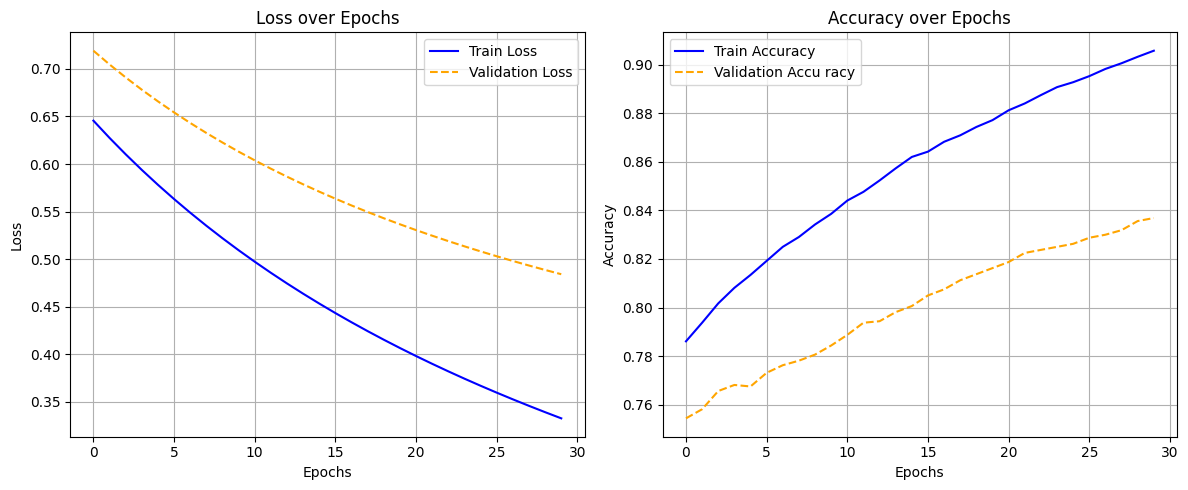

In [ ]:
# Storage for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 30

history_records = []
print("Starting training...")
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}")
    
    t_loss, t_acc = train_loop(train_loader, model, loss_fn, optimizer)
    v_loss, v_acc = validation_loop(val_loader, model, loss_fn)
    
    # Store history
    train_losses.append(t_loss)
    train_accuracies.append(t_acc)
    val_losses.append(v_loss)
    val_accuracies.append(v_acc)

    record = {
        "record_id": t,              # Epoch number as ID (or use uuid.uuid4() for global unique)
        "model_id": 4,
        "training_loss": t_loss,
        "validation_loss": v_loss,
        "training_acc": t_acc,   # Bonus: Track accuracy too!
        "validation_acc": v_acc
    }
    history_records.append(record)

print("Done!")


plt.figure(figsize=(12, 5))

# Plot 1: Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accu racy', color='orange', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

import os

output_file = "experiment_logs.csv"


new_df = pd.DataFrame(history_records)


final_df = new_df[['record_id', 'model_id', 'training_loss', 'validation_loss', 'training_acc', 'validation_acc']]


if os.path.exists(output_file):

    final_df.to_csv(output_file, mode='a', header=False, index=False)
    print(f"Appended {len(final_df)} records to existing {output_file}")
else:

    final_df.to_csv(output_file, mode='w', header=True, index=False)
    print(f"Created new file {output_file} with {len(final_df)} records")


print("\nLatest Records:")
print(final_df.head())

Appended 30 records to existing experiment_logs.csv

Latest Records:
   record_id  model_id  training_loss  validation_loss  training_acc  \
0          0         4       0.645610         0.719216      0.786094   
1          1         4       0.627459         0.704746      0.793750   
2          2         4       0.610220         0.691094      0.801719   
3          3         4       0.593788         0.678172      0.808125   
4          4         4       0.578106         0.665918      0.813438   

   validation_acc  
0        0.754375  
1        0.758125  
2        0.765625  
3        0.768125  
4        0.767500  


In [ ]:
test_loop(test_loader, model, "submission3.csv")

Saved predictions to submission3.csv
